In [7]:
from pathlib import Path

import numpy as np
import pandas as pd
import PIL

import tensorflow as tf
import tensorflow.keras.preprocessing.image as image
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers

import matplotlib.pyplot as plt
%matplotlib inline

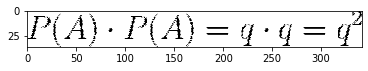

In [8]:
image_path = list(Path('/data/images/').rglob('*.png'))[100]
img = PIL.Image.open(image_path)
data = np.asarray(img)
plt.imshow(data, cmap='Greys')

In [9]:
image_dirname = Path('/data/images/')
data_generator = image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=False,
    vertical_flip=False,
    validation_split=0.1,
)

In [16]:
dgen_args = {
    'directory': image_dirname,
    'target_size': (64, 128),
    'class_mode': 'sparse',
    'batch_size': 64,
    'shuffle': True,
    'color_mode': 'grayscale'
}

train_dg = data_generator.flow_from_directory(subset='training', **dgen_args)
val_dg = data_generator.flow_from_directory(subset='validation', **dgen_args)

n_batches = len(train_dg)
trainX = []
for i in range(100):
    batch = train_dg.next()
    trainX.append(batch[0])
trainX = np.concatenate(trainX, axis=0)
data_generator.fit(trainX)

train_dg = data_generator.flow_from_directory(subset='training', **dgen_args)
val_dg = data_generator.flow_from_directory(subset='validation', **dgen_args)

Found 506829 images belonging to 3 classes.
Found 56313 images belonging to 3 classes.
Found 506829 images belonging to 3 classes.
Found 56313 images belonging to 3 classes.


batch mean: 214.0136
batch std: 93.5488
batch shape: (64, 64, 128, 1)
Standard Normal: False


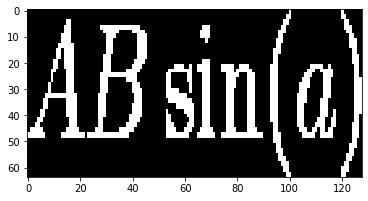

In [17]:
batch = train_dg.next()
X = batch[0]
print(f'batch mean: {X.mean():0.4f}')
print(f'batch std: {X.std():0.4f}')
print(f'batch shape: {X.shape}')
m, s = X.mean(), X.std()
print(f'Standard Normal: {(np.isclose(m,0, atol=0.1)) and (np.isclose(s, 1, atol=0.1))}')
plt.imshow(X[0, ..., 0], cmap='Greys')
plt.show()

In [18]:
def cv_model():
    input_shape = (64, 128, 1)
    input = layers.Input(shape=input_shape)
    tmp = input
    for i in range(5):
        conv = layers.Conv2D(64*(2**i), 3, activation='relu', kernel_initializer='he_uniform', padding='same')(tmp)
        pool = layers.MaxPooling2D(3, padding='same')(conv)
        tmp = pool
    flat = layers.Flatten()(tmp)
    for i in range(3):
        flat = layers.Dense(256//(2**i), activation='relu', kernel_initializer='he_uniform')(flat)
    output = layers.Dense(3, activation='softmax')(flat)
    model = models.Model(input, output)
    return model

def compile_model(model):
    opt = optimizers.Adam(0.001)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=opt,
        metrics=['sparse_categorical_accuracy']
    )
    return model

In [19]:
model = cv_model()
model = compile_model(model)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 128, 1)]      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 128, 64)       640       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 43, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 43, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 15, 128)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 15, 256)        295168    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 5, 256)         0   

In [ ]:
model.fit_generator(
    train_dg,
    steps_per_epoch=len(train_dg),
    validation_data=val_dg,
    validation_steps=len(val_dg),
    epochs=24,
    shuffle=True
)

Epoch 1/24


/home/myen/miniconda3/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/myen/miniconda3/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/myen/miniconda3/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/myen/miniconda3/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 735/7920 [=>............................] - ETA: 7:35 - loss: 8.6965 - sparse_categorical_accuracy: 0.8963